In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=231,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train_310.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test_310.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 783/783 [00:06<00:00, 122.81it/s]


In [10]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 114.70it/s]


In [11]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,  
            batch_size=len(Y),
            epochs=600, #600
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 6s 8ms/step - loss: 4.4883 - accuracy: 0.0294 - val_loss: 6.0630 - val_accuracy: 0.0357
Epoch 2/600
783/783 [==============================] - 0s 115us/step - loss: 4.2182 - accuracy: 0.0307 - val_loss: 6.0063 - val_accuracy: 0.0357
Epoch 3/600
783/783 [==============================] - 0s 128us/step - loss: 3.9547 - accuracy: 0.0511 - val_loss: 7.6821 - val_accuracy: 0.0255
Epoch 4/600
783/783 [==============================] - 0s 113us/step - loss: 3.7856 - accuracy: 0.0702 - val_loss: 9.6514 - val_accuracy: 0.0255
Epoch 5/600
783/783 [==============================] - 0s 113us/step - loss: 3.6266 - accuracy: 0.0805 - val_loss: 11.2712 - val_accuracy: 0.0255
Epoch 6/600
783/783 [==============================] - 0s 112us/step - loss: 3.4167 - accuracy: 0.1111 - val_loss: 11.8926 - val_accuracy: 0.0536
Epoch 7/600
783/783 [==============================] - 0s 114us/step - loss: 3.3490 

Epoch 57/600
783/783 [==============================] - 0s 124us/step - loss: 0.9554 - accuracy: 0.8072 - val_loss: 2.7101 - val_accuracy: 0.3393
Epoch 58/600
783/783 [==============================] - 0s 122us/step - loss: 0.9145 - accuracy: 0.8110 - val_loss: 2.6208 - val_accuracy: 0.3878
Epoch 59/600
783/783 [==============================] - 0s 137us/step - loss: 0.9028 - accuracy: 0.8314 - val_loss: 2.5261 - val_accuracy: 0.4235
Epoch 60/600
783/783 [==============================] - 0s 121us/step - loss: 0.8630 - accuracy: 0.8238 - val_loss: 2.4377 - val_accuracy: 0.4694
Epoch 61/600
783/783 [==============================] - 0s 123us/step - loss: 0.8346 - accuracy: 0.8531 - val_loss: 2.3629 - val_accuracy: 0.4974
Epoch 62/600
783/783 [==============================] - 0s 119us/step - loss: 0.8153 - accuracy: 0.8633 - val_loss: 2.3144 - val_accuracy: 0.5077
Epoch 63/600
783/783 [==============================] - 0s 130us/step - loss: 0.7861 - accuracy: 0.8544 - val_loss: 2.2639 -

783/783 [==============================] - 0s 114us/step - loss: 0.2695 - accuracy: 0.9693 - val_loss: 1.2738 - val_accuracy: 0.6837
Epoch 114/600
783/783 [==============================] - 0s 112us/step - loss: 0.2429 - accuracy: 0.9770 - val_loss: 1.2337 - val_accuracy: 0.7092
Epoch 115/600
783/783 [==============================] - 0s 111us/step - loss: 0.2564 - accuracy: 0.9770 - val_loss: 1.1929 - val_accuracy: 0.7219
Epoch 116/600
783/783 [==============================] - 0s 112us/step - loss: 0.2553 - accuracy: 0.9783 - val_loss: 1.1466 - val_accuracy: 0.7347
Epoch 117/600
783/783 [==============================] - 0s 114us/step - loss: 0.2337 - accuracy: 0.9847 - val_loss: 1.0896 - val_accuracy: 0.7398
Epoch 118/600
783/783 [==============================] - 0s 111us/step - loss: 0.2535 - accuracy: 0.9693 - val_loss: 1.0600 - val_accuracy: 0.7577
Epoch 119/600
783/783 [==============================] - 0s 116us/step - loss: 0.2267 - accuracy: 0.9860 - val_loss: 1.0416 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 122us/step - loss: 0.1933 - accuracy: 0.9796 - val_loss: 0.4982 - val_accuracy: 0.8929
Epoch 170/600
783/783 [==============================] - 0s 118us/step - loss: 0.1947 - accuracy: 0.9860 - val_loss: 0.4903 - val_accuracy: 0.8929
Epoch 171/600
783/783 [==============================] - 0s 127us/step - loss: 0.1896 - accuracy: 0.9872 - val_loss: 0.4829 - val_accuracy: 0.8929
Epoch 172/600
783/783 [==============================] - 0s 123us/step - loss: 0.1791 - accuracy: 0.9872 - val_loss: 0.4756 - val_accuracy: 0.8980
Epoch 173/600
783/783 [==============================] - 0s 120us/step - loss: 0.1871 - accuracy: 0.9885 - val_loss: 0.4683 - val_accuracy: 0.8980
Epoch 174/600
783/783 [==============================] - 0s 120us/step - loss: 0.2003 - accuracy: 0.9911 - val_loss: 0.4614 - val_accuracy: 0.9031
Epoch 175/600
783/783 [==============================] - 0s 120us/step - loss: 0.1857 - accuracy: 0.9898 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 135us/step - loss: 0.1765 - accuracy: 0.9860 - val_loss: 0.2621 - val_accuracy: 0.9439
Epoch 226/600
783/783 [==============================] - 0s 124us/step - loss: 0.1913 - accuracy: 0.9847 - val_loss: 0.2603 - val_accuracy: 0.9464
Epoch 227/600
783/783 [==============================] - 0s 126us/step - loss: 0.2034 - accuracy: 0.9796 - val_loss: 0.2585 - val_accuracy: 0.9490
Epoch 228/600
783/783 [==============================] - 0s 124us/step - loss: 0.1843 - accuracy: 0.9911 - val_loss: 0.2568 - val_accuracy: 0.9490
Epoch 229/600
783/783 [==============================] - 0s 124us/step - loss: 0.1936 - accuracy: 0.9911 - val_loss: 0.2553 - val_accuracy: 0.9490
Epoch 230/600
783/783 [==============================] - 0s 129us/step - loss: 0.2167 - accuracy: 0.9821 - val_loss: 0.2538 - val_accuracy: 0.9490
Epoch 231/600
783/783 [==============================] - 0s 131us/step - loss: 0.1901 - accuracy: 0.9860 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 141us/step - loss: 0.1905 - accuracy: 0.9885 - val_loss: 0.2073 - val_accuracy: 0.9592
Epoch 282/600
783/783 [==============================] - 0s 118us/step - loss: 0.1930 - accuracy: 0.9847 - val_loss: 0.2067 - val_accuracy: 0.9592
Epoch 283/600
783/783 [==============================] - 0s 126us/step - loss: 0.1913 - accuracy: 0.9847 - val_loss: 0.2061 - val_accuracy: 0.9592
Epoch 284/600
783/783 [==============================] - 0s 122us/step - loss: 0.1815 - accuracy: 0.9898 - val_loss: 0.2057 - val_accuracy: 0.9592
Epoch 285/600
783/783 [==============================] - 0s 132us/step - loss: 0.1793 - accuracy: 0.9860 - val_loss: 0.2052 - val_accuracy: 0.9592
Epoch 286/600
783/783 [==============================] - 0s 120us/step - loss: 0.1943 - accuracy: 0.9860 - val_loss: 0.2048 - val_accuracy: 0.9566
Epoch 287/600
783/783 [==============================] - 0s 134us/step - loss: 0.1811 - accuracy: 0.9911 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 126us/step - loss: 0.1774 - accuracy: 0.9923 - val_loss: 0.1879 - val_accuracy: 0.9617
Epoch 338/600
783/783 [==============================] - 0s 127us/step - loss: 0.1998 - accuracy: 0.9821 - val_loss: 0.1876 - val_accuracy: 0.9617
Epoch 339/600
783/783 [==============================] - 0s 131us/step - loss: 0.1913 - accuracy: 0.9911 - val_loss: 0.1874 - val_accuracy: 0.9617
Epoch 340/600
783/783 [==============================] - 0s 126us/step - loss: 0.1918 - accuracy: 0.9847 - val_loss: 0.1872 - val_accuracy: 0.9617
Epoch 341/600
783/783 [==============================] - 0s 132us/step - loss: 0.2030 - accuracy: 0.9808 - val_loss: 0.1871 - val_accuracy: 0.9617
Epoch 342/600
783/783 [==============================] - 0s 135us/step - loss: 0.1900 - accuracy: 0.9821 - val_loss: 0.1869 - val_accuracy: 0.9617
Epoch 343/600
783/783 [==============================] - 0s 122us/step - loss: 0.1857 - accuracy: 0.9834 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 127us/step - loss: 0.1798 - accuracy: 0.9872 - val_loss: 0.1805 - val_accuracy: 0.9643
Epoch 394/600
783/783 [==============================] - 0s 130us/step - loss: 0.1833 - accuracy: 0.9834 - val_loss: 0.1804 - val_accuracy: 0.9643
Epoch 395/600
783/783 [==============================] - 0s 132us/step - loss: 0.1983 - accuracy: 0.9872 - val_loss: 0.1803 - val_accuracy: 0.9643
Epoch 396/600
783/783 [==============================] - 0s 140us/step - loss: 0.1988 - accuracy: 0.9821 - val_loss: 0.1802 - val_accuracy: 0.9643
Epoch 397/600
783/783 [==============================] - 0s 142us/step - loss: 0.1704 - accuracy: 0.9898 - val_loss: 0.1801 - val_accuracy: 0.9643
Epoch 398/600
783/783 [==============================] - 0s 130us/step - loss: 0.2017 - accuracy: 0.9821 - val_loss: 0.1800 - val_accuracy: 0.9643
Epoch 399/600
783/783 [==============================] - 0s 152us/step - loss: 0.1657 - accuracy: 0.9936 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 116us/step - loss: 0.1940 - accuracy: 0.9808 - val_loss: 0.1760 - val_accuracy: 0.9643
Epoch 450/600
783/783 [==============================] - 0s 112us/step - loss: 0.1949 - accuracy: 0.9821 - val_loss: 0.1760 - val_accuracy: 0.9643
Epoch 451/600
783/783 [==============================] - 0s 111us/step - loss: 0.1799 - accuracy: 0.9860 - val_loss: 0.1760 - val_accuracy: 0.9643
Epoch 452/600
783/783 [==============================] - 0s 123us/step - loss: 0.1967 - accuracy: 0.9847 - val_loss: 0.1759 - val_accuracy: 0.9617
Epoch 453/600
783/783 [==============================] - 0s 117us/step - loss: 0.1798 - accuracy: 0.9898 - val_loss: 0.1758 - val_accuracy: 0.9617
Epoch 454/600
783/783 [==============================] - 0s 113us/step - loss: 0.1888 - accuracy: 0.9860 - val_loss: 0.1758 - val_accuracy: 0.9617
Epoch 455/600
783/783 [==============================] - 0s 111us/step - loss: 0.1895 - accuracy: 0.9860 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 129us/step - loss: 0.1931 - accuracy: 0.9821 - val_loss: 0.1745 - val_accuracy: 0.9617
Epoch 506/600
783/783 [==============================] - 0s 123us/step - loss: 0.1999 - accuracy: 0.9783 - val_loss: 0.1745 - val_accuracy: 0.9617
Epoch 507/600
783/783 [==============================] - 0s 125us/step - loss: 0.1784 - accuracy: 0.9911 - val_loss: 0.1745 - val_accuracy: 0.9617
Epoch 508/600
783/783 [==============================] - 0s 121us/step - loss: 0.1932 - accuracy: 0.9911 - val_loss: 0.1745 - val_accuracy: 0.9617
Epoch 509/600
783/783 [==============================] - 0s 125us/step - loss: 0.1614 - accuracy: 0.9923 - val_loss: 0.1745 - val_accuracy: 0.9617
Epoch 510/600
783/783 [==============================] - 0s 129us/step - loss: 0.2059 - accuracy: 0.9834 - val_loss: 0.1744 - val_accuracy: 0.9617
Epoch 511/600
783/783 [==============================] - 0s 124us/step - loss: 0.2066 - accuracy: 0.9834 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 125us/step - loss: 0.1757 - accuracy: 0.9911 - val_loss: 0.1737 - val_accuracy: 0.9643
Epoch 562/600
783/783 [==============================] - 0s 138us/step - loss: 0.1836 - accuracy: 0.9936 - val_loss: 0.1737 - val_accuracy: 0.9643
Epoch 563/600
783/783 [==============================] - 0s 126us/step - loss: 0.1864 - accuracy: 0.9821 - val_loss: 0.1736 - val_accuracy: 0.9643
Epoch 564/600
783/783 [==============================] - 0s 127us/step - loss: 0.1967 - accuracy: 0.9872 - val_loss: 0.1736 - val_accuracy: 0.9643
Epoch 565/600
783/783 [==============================] - 0s 126us/step - loss: 0.1838 - accuracy: 0.9847 - val_loss: 0.1736 - val_accuracy: 0.9643
Epoch 566/600
783/783 [==============================] - 0s 125us/step - loss: 0.1892 - accuracy: 0.9898 - val_loss: 0.1735 - val_accuracy: 0.9643
Epoch 567/600
783/783 [==============================] - 0s 128us/step - loss: 0.1852 - accuracy: 0.9847 - val_loss: 0

FileNotFoundError: [Errno 2] No such file or directory: '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/rlsherc_14_test1.png'

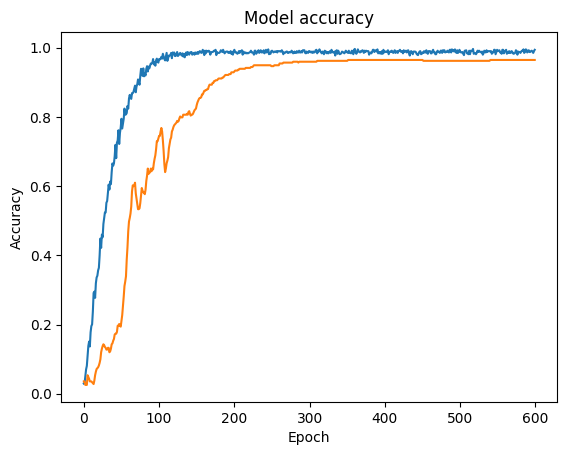

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [ ]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
#from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [ ]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

# Plotting confusion matrix

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [ ]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [13]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r    
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class):
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 

    n_states=32 
    n_actions=3
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1
    max_steps = 32  
#     numsteps = []
#     avg_numsteps = []
    all_rewards = []
#     x_trnew=[]
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
#             x_tr_1=[]
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
#                 rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v] 
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):              
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)


                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
        #             with torch.no_grad():
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1    
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)

        x_tr = torch.stack(x_tr)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
Train = pickle.load(open(C.data_dir+"train_310.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|██████████████████████████████████████| 783/783 [00:00<00:00, 19561.96it/s]


### epoch 1

In [ ]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 12%|█████                                     | 95/783 [01:09<08:37,  1.33it/s]


 25%|██████████                               | 192/783 [02:20<06:18,  1.56it/s]


 32%|████████████▉                            | 248/783 [02:59<06:24,  1.39it/s]

In [ ]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test4.png")
plt.grid()

In [ ]:
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [ ]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test5.png', labels, ymap=None, figsize=(18,18))

### epoch 2 

In [ ]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

In [ ]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test2.png")
#plt.grid()

In [ ]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test6.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [ ]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 4

In [ ]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 5

In [ ]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### test accuracy   -through RL get test data

In [26]:
Test = pickle.load(open(C.data_dir+"test.pkl","rb"))

X_test_2 = []
X_test_3 = []
labels_test = []
for i in tqdm(range(len(Test['pose']))): 
    test_or_p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    test_or_p = zoom(test_or_p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    test_or_p = normlize_range(test_or_p)
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   
    
    M = get_CG(p,C)
       
    p = torch.tensor(p)
    M = torch.tensor(M)

    X_test_2.append(M)
    X_test_3.append(p)
    labels_test.append(label)

X_test_2 = np.stack(X_test_0) 
X_test_3 = np.stack(X_test_1)  
labels_test  = np.stack(labels_test)


100%|████████████████████████████████████████| 840/840 [00:06<00:00, 127.62it/s]


In [27]:

def test(X_TEST): #x表示x_main，输入全局帧  label表示标签 
#     def train(x_m,x,oridata,labels): #x表示x_main，输入全局帧  label表示标签 
    n_states=20 #状态数量 这里应该指关键帧f的数量为30
    n_actions=3 #输出动作
    # env.seed(random_seed)
#     policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
#     Policy  = torch.load('model/policy_net.pth')
    policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
    max_steps = 20  #最大
    XM=[]
    for v in tqdm(range(len(X_TEST))):
        log_probs = []
        rewards = []
        Action=[]
        if len(oridata[v])>=10:
            rng = default_rng()
            MM=np.sort(rng.choice(len(X_TEST[v]),size=10,replace=False))   
        else:
            MM=np.sort(rng.choice(len(X_TEST[v]),size=10,replace=True))  
        XX=X_TEST[v]  #输入数据
        for steps in range(len(MM)):
            state = XX[MM[steps]]
            state = state.reshape(1, 1, 22, 3)
            state = torch.Tensor(state)
            action, log_prob = policy_net.select_action(state)
#             action, log_prob = policy_net(state)
            Action.append(action)

            if action == 0 :
                if steps == 0:
                    a = 0
                else:
                    a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                d = min(1, MM[steps] - a)
                MM[steps] = MM[steps] - d
            if action == 1:
                MM[steps] = MM[steps]
            if action == 2:
                if steps == len(MM) - 1:
                    a = len(XX)
                else:
                    a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                d = min(1, a - MM[steps] - 1)
                MM[steps] = MM[steps] + d
        xm1 = XX[MM]
        XM.append(xm1)
                      
    return XM
    
XM = test(X_test_1)

100%|█████████████████████████████████████████| 840/840 [00:11<00:00, 72.26it/s]


In [28]:
test_0 =[]
test_1 = []


for i in tqdm(range(len(XM))):
    test_p = np.copy(XM[i]).reshape([-1,22,3]) 
    test_p = np.array(test_p)
    test_p = zoom(test_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    test_p = normlize_range(test_p)

    test_M = get_CG(test_p,C)

    test_0.append(test_M)
    test_1.append(test_p)

test_0 = np.stack(test_0)
test_1 = np.stack(test_1)


100%|████████████████████████████████████████| 840/840 [00:05<00:00, 141.03it/s]


In [29]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  #history使得训练结果可视化
            batch_size=len(Y),
            epochs=700, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([test_0,test_1],labels_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0150 - accuracy: 0.9985 - val_loss: 0.4157 - val_accuracy: 0.9167
Epoch 2/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.1000 - accuracy: 0.9709 - val_loss: 0.4984 - val_accuracy: 0.9000
Epoch 3/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0512 - accuracy: 0.9862 - val_loss: 0.6469 - val_accuracy: 0.8833
Epoch 4/700
1960/1960 [==============================] - 0s 43us/step - loss: 0.0815 - accuracy: 0.9760 - val_loss: 0.6361 - val_accuracy: 0.8762
Epoch 5/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0933 - accuracy: 0.9750 - val_loss: 0.6273 - val_accuracy: 0.8774
Epoch 6/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0492 - accuracy: 0.9888 - val_loss: 0.6433 - val_accuracy: 0.8833
Epoch 7/700
1960/1960 [==============================] - 0s 46us/step - loss: 

Epoch 57/700
1960/1960 [==============================] - 0s 58us/step - loss: 0.0226 - accuracy: 0.9944 - val_loss: 0.4755 - val_accuracy: 0.9167
Epoch 58/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0.4742 - val_accuracy: 0.9167
Epoch 59/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0196 - accuracy: 0.9969 - val_loss: 0.4730 - val_accuracy: 0.9179
Epoch 60/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0266 - accuracy: 0.9949 - val_loss: 0.4718 - val_accuracy: 0.9179
Epoch 61/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0210 - accuracy: 0.9964 - val_loss: 0.4709 - val_accuracy: 0.9179
Epoch 62/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0184 - accuracy: 0.9985 - val_loss: 0.4700 - val_accuracy: 0.9179
Epoch 63/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0

Epoch 113/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.4419 - val_accuracy: 0.9238
Epoch 114/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0246 - accuracy: 0.9964 - val_loss: 0.4415 - val_accuracy: 0.9238
Epoch 115/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0245 - accuracy: 0.9954 - val_loss: 0.4410 - val_accuracy: 0.9238
Epoch 116/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0166 - accuracy: 0.9980 - val_loss: 0.4405 - val_accuracy: 0.9238
Epoch 117/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0184 - accuracy: 0.9964 - val_loss: 0.4402 - val_accuracy: 0.9238
Epoch 118/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0181 - accuracy: 0.9964 - val_loss: 0.4397 - val_accuracy: 0.9238
Epoch 119/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0166 - accuracy: 0.9969 - val_

Epoch 169/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0164 - accuracy: 0.9995 - val_loss: 0.4294 - val_accuracy: 0.9262
Epoch 170/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0155 - accuracy: 0.9980 - val_loss: 0.4294 - val_accuracy: 0.9262
Epoch 171/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0161 - accuracy: 0.9974 - val_loss: 0.4293 - val_accuracy: 0.9250
Epoch 172/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0179 - accuracy: 0.9985 - val_loss: 0.4293 - val_accuracy: 0.9262
Epoch 173/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0206 - accuracy: 0.9969 - val_loss: 0.4293 - val_accuracy: 0.9262
Epoch 174/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0209 - accuracy: 0.9980 - val_loss: 0.4292 - val_accuracy: 0.9274
Epoch 175/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0240 - accuracy: 0.9954 - val_

Epoch 225/700
1960/1960 [==============================] - 0s 52us/step - loss: 0.0214 - accuracy: 0.9964 - val_loss: 0.4218 - val_accuracy: 0.9274
Epoch 226/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0154 - accuracy: 0.9990 - val_loss: 0.4216 - val_accuracy: 0.9274
Epoch 227/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0196 - accuracy: 0.9964 - val_loss: 0.4215 - val_accuracy: 0.9274
Epoch 228/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0199 - accuracy: 0.9954 - val_loss: 0.4213 - val_accuracy: 0.9274
Epoch 229/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.4211 - val_accuracy: 0.9274
Epoch 230/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0205 - accuracy: 0.9969 - val_loss: 0.4209 - val_accuracy: 0.9274
Epoch 231/700
1960/1960 [==============================] - 0s 61us/step - loss: 0.0183 - accuracy: 0.9969 - val_

Epoch 281/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 282/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0154 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9262
Epoch 283/700
1960/1960 [==============================] - 0s 52us/step - loss: 0.0218 - accuracy: 0.9959 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 284/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0171 - accuracy: 0.9974 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 285/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 286/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0147 - accuracy: 0.9974 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 287/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0190 - accuracy: 0.9974 - val_

Epoch 337/700
1960/1960 [==============================] - 0s 63us/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.4180 - val_accuracy: 0.9262
Epoch 338/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0186 - accuracy: 0.9974 - val_loss: 0.4179 - val_accuracy: 0.9262
Epoch 339/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0209 - accuracy: 0.9964 - val_loss: 0.4178 - val_accuracy: 0.9262
Epoch 340/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0156 - accuracy: 0.9974 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 341/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0150 - accuracy: 0.9974 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 342/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0149 - accuracy: 0.9995 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 343/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0203 - accuracy: 0.9959 - val_

Epoch 393/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0185 - accuracy: 0.9980 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 394/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 395/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 396/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 397/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0177 - accuracy: 0.9964 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 398/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0220 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 399/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0119 - accuracy: 1.0000 - val_

Epoch 449/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 450/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0147 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 451/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0198 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 452/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.4156 - val_accuracy: 0.9238
Epoch 453/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0165 - accuracy: 0.9985 - val_loss: 0.4157 - val_accuracy: 0.9238
Epoch 454/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.4157 - val_accuracy: 0.9250
Epoch 455/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0148 - accuracy: 0.9974 - val_

Epoch 505/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0163 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9238
Epoch 506/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0221 - accuracy: 0.9954 - val_loss: 0.4189 - val_accuracy: 0.9238
Epoch 507/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0213 - accuracy: 0.9964 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 508/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0165 - accuracy: 0.9990 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 509/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 510/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.4190 - val_accuracy: 0.9250
Epoch 511/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0207 - accuracy: 0.9949 - val_

Epoch 561/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0159 - accuracy: 0.9969 - val_loss: 0.4206 - val_accuracy: 0.9262
Epoch 562/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0221 - accuracy: 0.9969 - val_loss: 0.4207 - val_accuracy: 0.9262
Epoch 563/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0209 - accuracy: 0.9959 - val_loss: 0.4207 - val_accuracy: 0.9262
Epoch 564/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.4208 - val_accuracy: 0.9262
Epoch 565/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.4209 - val_accuracy: 0.9262
Epoch 566/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0175 - accuracy: 0.9974 - val_loss: 0.4209 - val_accuracy: 0.9262
Epoch 567/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0175 - accuracy: 0.9969 - val_

Epoch 617/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.4214 - val_accuracy: 0.9250
Epoch 618/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.4214 - val_accuracy: 0.9250
Epoch 619/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.4213 - val_accuracy: 0.9250
Epoch 620/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0176 - accuracy: 0.9969 - val_loss: 0.4213 - val_accuracy: 0.9250
Epoch 621/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0214 - accuracy: 0.9959 - val_loss: 0.4212 - val_accuracy: 0.9250
Epoch 622/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 0.4211 - val_accuracy: 0.9250
Epoch 623/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0158 - accuracy: 0.9964 - val_

Epoch 673/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.4187 - val_accuracy: 0.9226
Epoch 674/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.4187 - val_accuracy: 0.9226
Epoch 675/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0154 - accuracy: 0.9969 - val_loss: 0.4188 - val_accuracy: 0.9226
Epoch 676/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9226
Epoch 677/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0127 - accuracy: 0.9980 - val_loss: 0.4190 - val_accuracy: 0.9226
Epoch 678/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.4192 - val_accuracy: 0.9226
Epoch 679/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0165 - accuracy: 0.9974 - val_

In [30]:
DD_Net.save_weights('weights/coarse_heavy.h2')

In [31]:
Y_pred_rltest = DD_Net.predict([test_0,test_1])

In [32]:
labels_test = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_test[i])
    
y_pred_test = []
for i in np.argmax(Y_pred_rltest,axis=1):
    y_pred_test.append(labels_test[i])

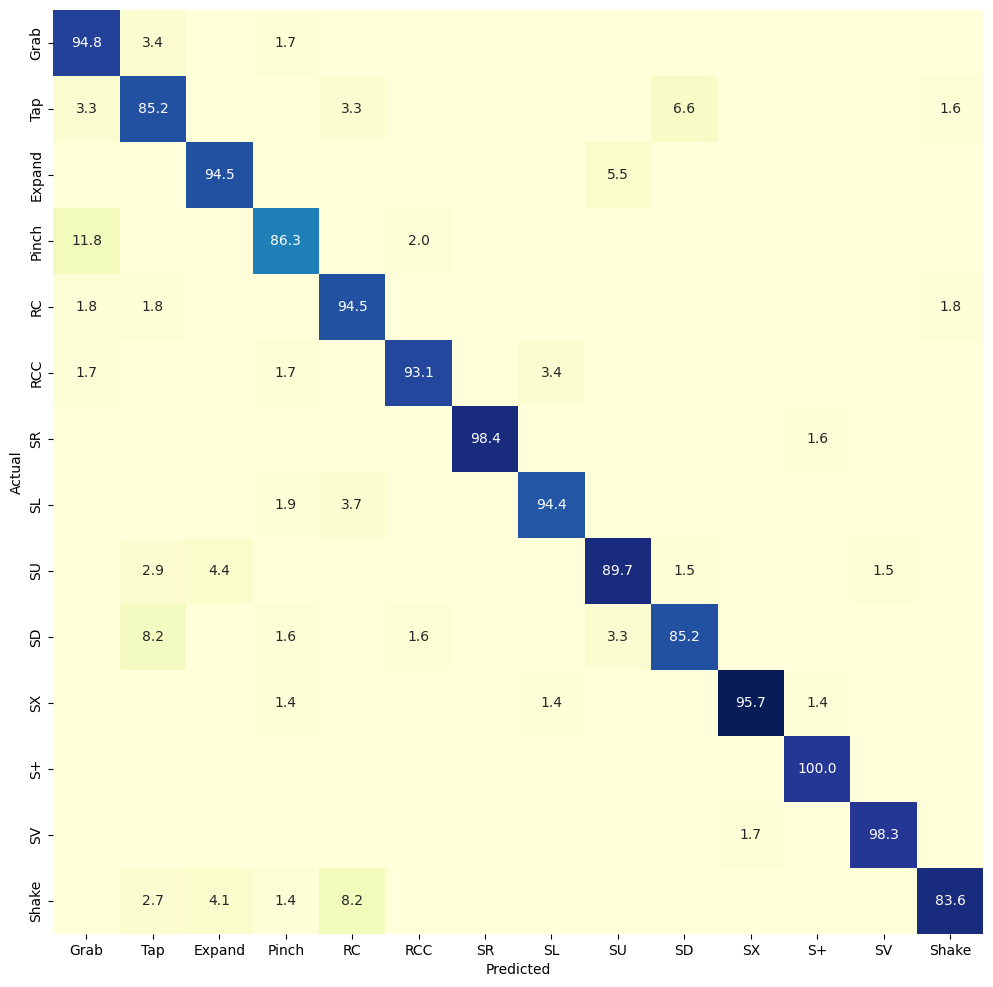

In [33]:
cm_analysis(y_true,y_pred_test, 'images/rlSHREC_14_test3.png', labels_test, ymap=None, figsize=(12,12))